<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/adding_C4/C4/W2/ungraded_labs/C4_W2_Lab_2_single_layer_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [2]:
#!pip install tensorflow==2.5.0

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

2.7.0


In [6]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

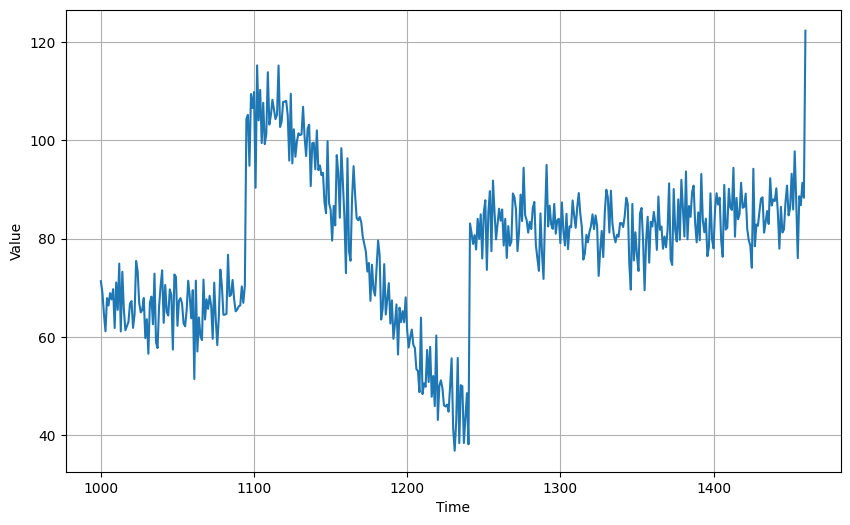

In [7]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [9]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
val_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
print(dataset)

l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

# 采用两种优化器，结果差不多。但是SGD看起来收敛的更加平稳
# optimizer = tf.keras.optimizers.Adam(learning_rate=2e-3)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset,epochs=100, validation_data=val_dataset)

print("Layer weights {}".format(l0.get_weights()))


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Epoch 1/100
31/31 [==============================] - 1s 22ms/step - loss: 756.9258 - val_loss: 441.0768
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 206.9404 - val_loss: 146.5930
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 164.2616 - val_loss: 135.6031
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 135.9758 - val_loss: 111.5444
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 119.5938 - val_loss: 104.6626
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 110.1070 - val_loss: 97.9771
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 103.2758 - val_loss: 91.1253
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 100.0232 - val_loss: 89.0766
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 96.9475 - val_loss: 85

31/31 [==============================] - 0s 5ms/step - loss: 47.1847 - val_loss: 53.4829
Epoch 81/100
31/31 [==============================] - 0s 5ms/step - loss: 47.8166 - val_loss: 46.0710
Epoch 82/100
31/31 [==============================] - 0s 5ms/step - loss: 46.3021 - val_loss: 45.8962
Epoch 83/100
31/31 [==============================] - 0s 5ms/step - loss: 46.4305 - val_loss: 45.8878
Epoch 84/100
31/31 [==============================] - 0s 5ms/step - loss: 46.3052 - val_loss: 49.8425
Epoch 85/100
31/31 [==============================] - 0s 5ms/step - loss: 46.0503 - val_loss: 45.8523
Epoch 86/100
31/31 [==============================] - 0s 5ms/step - loss: 45.9440 - val_loss: 46.0354
Epoch 87/100
31/31 [==============================] - 0s 5ms/step - loss: 45.9875 - val_loss: 49.6255
Epoch 88/100
31/31 [==============================] - 0s 5ms/step - loss: 46.3779 - val_loss: 46.8924
Epoch 89/100
31/31 [==============================] - 0s 5ms/step - loss: 46.1763 - val_loss: 4

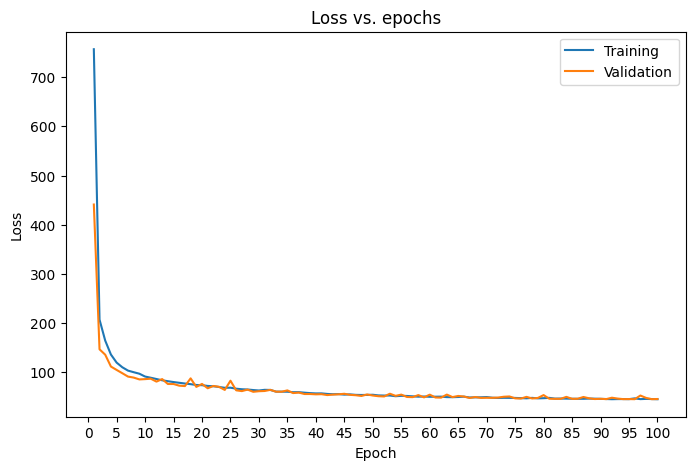

In [10]:
plt.figure(figsize=(8, 5))
max_epoch = len(history.history['loss'])
epochs = range(1, max_epoch+1)
if max_epoch <= 20:
    xticks = range(0, max_epoch+1)
else:
    xticks = range(0, max_epoch+1, (max_epoch-1)//20+1)

plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(xticks)
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

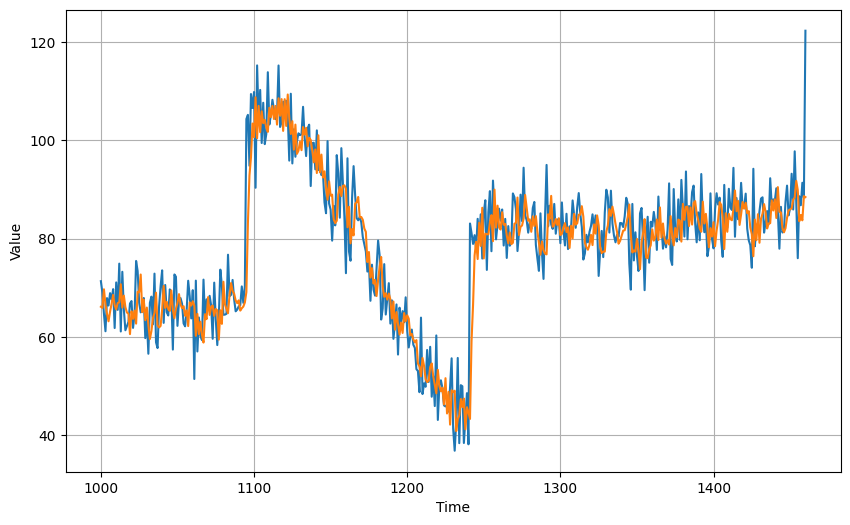

In [11]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)
plt.show()

In [12]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()) 

44.55358
4.9185853
